## Test E-matrix estimation on calibrated images
- Images are taken from https://www.microsoft.com/en-us/research/project/a-flexible-new-technique-for-camera-calibration-2/
- Two 480 x 640 RGB images
- Using Harris corners to find Correspondence candidates
- Hand-pick a few true correspondences, to estimate a ground-truth E for comparison

## 1. Retrieve corners from calibrated images

In [2]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread('teatin1.png') # third dimension: colour (BGR)
img2 = cv2.imread('teatin2.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

In [3]:
img2.shape

(480, 640, 3)

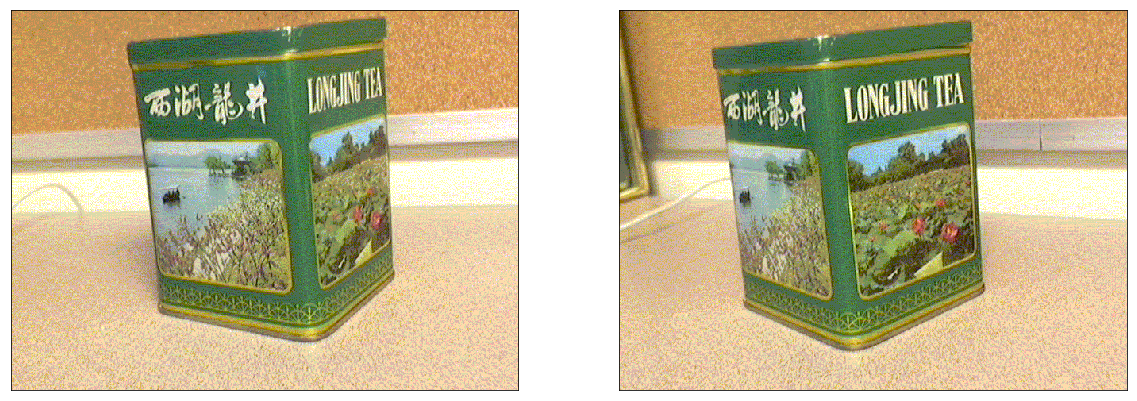

In [4]:
plt.figure(1, figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap = None, interpolation = None) 
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

plt.subplot(1, 2, 2)
plt.imshow(img2, cmap = None, interpolation = None)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

plt.show()

In [4]:
def img2harris(img, window=13, n_top=200):
    """
    Returns numpy array (num_corners, 2) of top n_top harris corners.

    Parameters
    ----------
    img : BGR image with values in 0-255
        Image returned by call to cv2.imread().
    window : integer
        Image is split into a mosaic of window x window regions. 
        For each region, only the highest corner value is kept.
    n_top: integer
        The remaining corner values are sorted, and the coordinates 
        of the top n_top corners are returned.
    
    """
    
    # convert to gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    
    # find harris corners
    dst = cv2.cornerHarris(gray,2,3,0.04)
    
    highest = np.zeros_like(dst)
    
    # split into mosaic, keep only highest value per region
    for r in range(0, dst.shape[0], 13):
        r_end = min(r + window, dst.shape[0])
        for c in range(0, dst.shape[1], 13):
            # define end of window (limited by right edge of image)
            c_end = min(c + window, dst.shape[1])
            
            # write highest value to zeroed matrix
            m = np.max(dst[r:r_end, c:c_end])
            i = np.where(dst[r:r_end, c:c_end] == m)
            
            highest[r:r_end, c:c_end][i] = m
    
    # get top 200 from highest
    ind = np.argpartition(highest, -n_top, None)[-n_top:]
    ind = np.unravel_index(ind, highest.shape)
    
    return ind

In [5]:
# Store Harris corners in ind1, ind2
ind1 = img2harris(img1)
ind2 = img2harris(img2)

img1_disp = img1.copy()
img2_disp = img2.copy()

# Mark corners with red dots
# img1_disp[ind1] = [0,0,255]
# img2_disp[ind2] = [0,0,255]

for pt1 in (np.array(ind1).T):
    img1_disp = cv2.circle(img1_disp,tuple([pt1[1],pt1[0]]),2,(255,0,0),-1)

for pt2 in (np.array(ind2).T):
    img2_disp = cv2.circle(img2_disp,tuple([pt2[1],pt2[0]]),2,(255,0,0),-1)

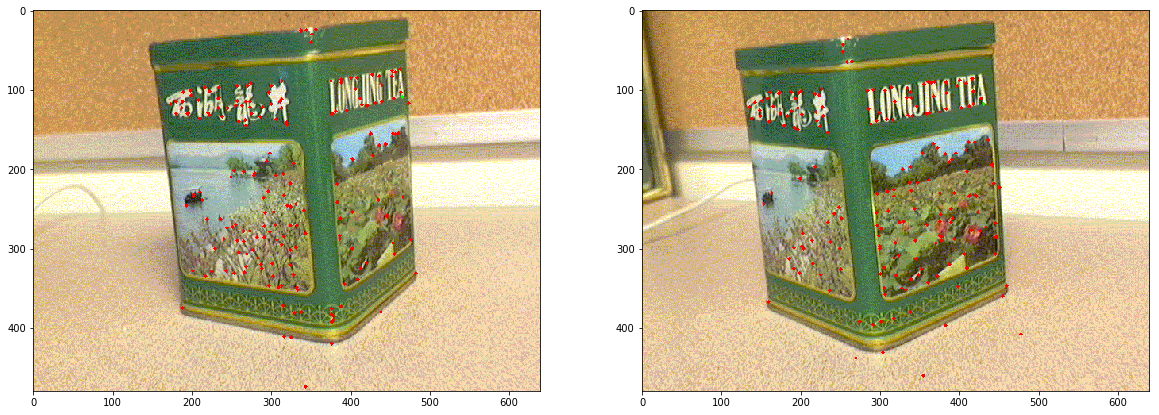

In [46]:
# For choosing correspondences manually ---
co1 = [109., 465.]
co2 = [118., 430.]
co1.reverse()
co2.reverse()
co1 = np.array(co1)
co2 = np.array(co2)
img1_disp = cv2.circle(img1_disp,tuple(co1.astype(int)),2,(0,255,0),-1)
img2_disp = cv2.circle(img2_disp,tuple(co2.astype(int)),2,(0,255,0),-1)
# ---

# Display results
plt.figure(1, figsize=(20,10))

plt.subplot(1, 2, 1)
plt.imshow(img1_disp)
# plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img2_disp)
# plt.xticks([]), plt.yticks([])

plt.show()

In [6]:
# Collect indices of corners
pts1 = np.array(ind1).T.astype(float)
pts2 = np.array(ind2).T.astype(float)

## 2. Run Particle Filter

In [133]:
import helpers
import numpy as np
from helpers import projectPoints, transformCamera
from math import sin, cos, pi

In [214]:
from importlib import reload
reload(helpers)

<module 'helpers' from 'D:\\Courses\\NUS\\DCVPC\\code\\helpers.py'>

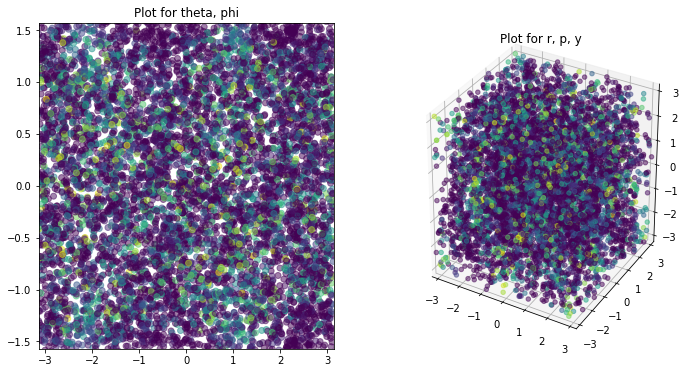

First 200 scores: [0, 0, 15, 79, 72, 69, 0, 0, 4, 0, 1, 0, 95, 1, 0, 36, 1, 6, 0, 2, 72, 11, 0, 11, 0, 0, 0, 0, 0, 0, 34, 0, 1, 94, 0, 0, 0, 0, 103, 0, 0, 0, 62, 0, 54, 10, 0, 0, 74, 0, 73, 79, 0, 6, 84, 11, 96, 0, 1, 0, 0, 0, 81, 2, 0, 5, 18, 0, 27, 0, 1, 56, 86, 1, 1, 0, 0, 0, 41, 11, 0, 57, 36, 94, 25, 0, 100, 24, 20, 0, 77, 76, 11, 18, 0, 30, 0, 0, 35, 0, 0, 0, 2, 0, 20, 19, 0, 60, 0, 0, 22, 3, 23, 96, 0, 0, 0, 1, 42, 8, 81, 104, 0, 12, 0, 76, 0, 26, 0, 0, 34, 0, 0, 20, 3, 0, 0, 78, 0, 98, 93, 9, 28, 0, 0, 29, 36, 52, 1, 32, 0, 1, 0, 12, 30, 0, 94, 55, 33, 17, 28, 0, 25, 3, 60, 42, 44, 75, 8, 0, 0, 0, 30, 65, 103, 0, 0, 16, 0, 0, 2, 2, 19, 0, 0, 0, 49, 1, 88, 0, 53, 48, 4, 0, 47, 0, 86, 101, 10, 15]
Non-match ratio: 0.000000 (0/176071)
Sigma: ['0.080000', '0.080000', '0.080000', '0.080000', '0.080000']
Epsilon: 3.000000
Iteration: 1
Elapsed time: 9.866343s


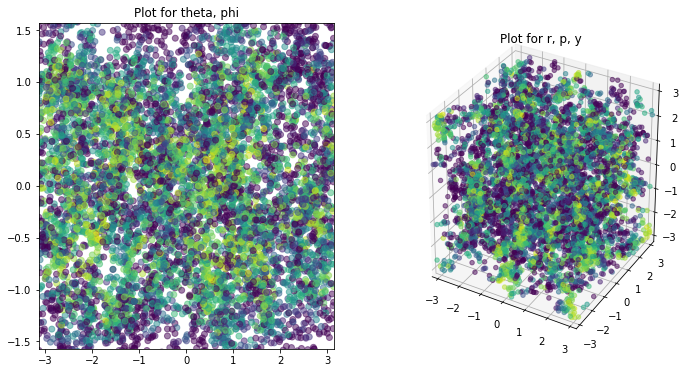

First 200 scores: [1, 0, 63, 105, 17, 23, 3, 99, 20, 7, 10, 91, 82, 8, 58, 9, 77, 45, 81, 2, 97, 91, 23, 61, 0, 10, 90, 83, 0, 94, 35, 67, 0, 115, 7, 48, 12, 83, 78, 0, 42, 79, 50, 1, 0, 104, 59, 17, 81, 96, 28, 29, 73, 51, 39, 82, 20, 0, 9, 3, 61, 97, 0, 0, 94, 104, 52, 6, 105, 0, 48, 75, 88, 36, 90, 73, 79, 19, 97, 80, 0, 93, 21, 2, 1, 82, 102, 19, 0, 63, 103, 45, 12, 3, 0, 0, 33, 80, 2, 10, 77, 92, 0, 0, 68, 0, 0, 23, 87, 53, 0, 49, 106, 95, 80, 89, 103, 25, 77, 73, 76, 86, 0, 45, 87, 4, 20, 100, 79, 80, 83, 12, 9, 77, 0, 62, 77, 0, 0, 67, 105, 87, 103, 61, 84, 85, 107, 80, 78, 98, 57, 91, 57, 13, 64, 51, 0, 75, 0, 30, 49, 105, 8, 82, 98, 31, 35, 63, 0, 86, 58, 0, 87, 72, 86, 51, 0, 110, 35, 0, 34, 88, 92, 9, 26, 52, 11, 76, 0, 0, 88, 97, 35, 32, 5, 83, 65, 11, 29, 29]
Non-match ratio: 0.000000 (0/386561)
Sigma: ['0.056000', '0.056000', '0.056000', '0.056000', '0.056000']
Epsilon: 2.700000
Iteration: 6
Elapsed time: 62.074563s


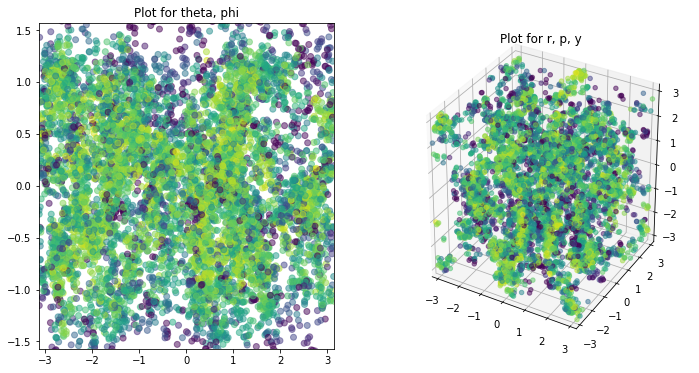

First 200 scores: [105, 93, 47, 64, 89, 91, 81, 76, 79, 99, 103, 99, 92, 82, 103, 27, 0, 53, 72, 72, 79, 54, 87, 82, 0, 90, 51, 68, 104, 1, 79, 1, 84, 89, 70, 68, 85, 87, 99, 88, 96, 68, 102, 0, 92, 97, 14, 83, 89, 92, 61, 97, 1, 72, 35, 79, 0, 96, 64, 0, 78, 92, 25, 106, 42, 105, 105, 89, 64, 82, 0, 90, 64, 62, 96, 20, 42, 53, 72, 73, 72, 37, 3, 106, 89, 11, 60, 12, 100, 66, 86, 48, 38, 90, 0, 73, 104, 53, 78, 106, 74, 74, 30, 54, 0, 91, 53, 17, 98, 51, 24, 97, 38, 30, 101, 69, 84, 0, 91, 68, 106, 99, 95, 87, 0, 69, 100, 42, 79, 19, 94, 102, 89, 90, 89, 1, 96, 39, 98, 110, 84, 45, 80, 82, 14, 40, 72, 79, 38, 68, 78, 89, 32, 54, 74, 72, 75, 86, 85, 110, 96, 84, 86, 49, 98, 78, 107, 35, 107, 80, 85, 88, 96, 105, 83, 56, 0, 72, 9, 93, 83, 25, 70, 57, 31, 41, 1, 21, 103, 87, 88, 87, 40, 78, 104, 98, 74, 41, 89, 100]
Non-match ratio: 0.000000 (0/564557)
Sigma: ['0.039200', '0.039200', '0.039200', '0.039200', '0.039200']
Epsilon: 2.430000
Iteration: 11
Elapsed time: 122.852300s


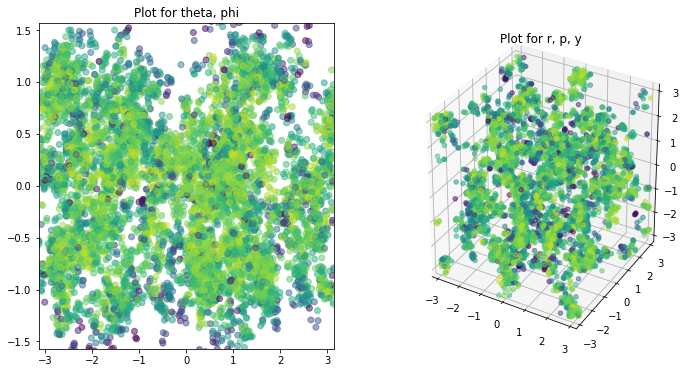

First 200 scores: [82, 70, 36, 20, 78, 82, 92, 80, 98, 73, 71, 103, 96, 95, 94, 107, 70, 66, 88, 83, 90, 78, 93, 85, 89, 44, 96, 84, 70, 101, 93, 81, 82, 79, 95, 105, 79, 82, 104, 20, 65, 47, 88, 102, 95, 104, 94, 86, 99, 76, 71, 94, 60, 95, 79, 67, 93, 76, 67, 96, 54, 95, 103, 93, 84, 87, 81, 100, 101, 90, 71, 88, 59, 76, 79, 37, 95, 48, 69, 26, 39, 88, 60, 69, 76, 85, 99, 97, 93, 84, 87, 26, 80, 70, 19, 88, 92, 101, 56, 17, 89, 65, 101, 72, 102, 98, 74, 62, 78, 42, 56, 82, 4, 67, 90, 79, 103, 70, 100, 92, 87, 93, 95, 69, 90, 98, 90, 93, 95, 91, 38, 78, 94, 95, 100, 94, 102, 99, 80, 88, 87, 76, 79, 108, 66, 67, 84, 100, 104, 27, 105, 97, 59, 82, 83, 102, 70, 37, 107, 99, 72, 81, 38, 92, 73, 41, 73, 27, 86, 93, 84, 93, 99, 86, 81, 99, 97, 77, 42, 96, 98, 76, 92, 109, 93, 91, 96, 96, 38, 80, 62, 95, 71, 82, 83, 63, 71, 79, 98, 97]
Non-match ratio: 0.000000 (0/632095)
Sigma: ['0.027440', '0.027440', '0.027440', '0.027440', '0.027440']
Epsilon: 2.187000
Iteration: 16
Elapsed time: 187.581

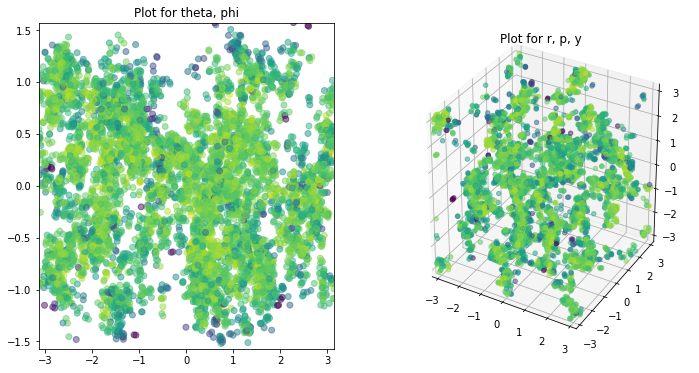

First 200 scores: [93, 95, 100, 92, 93, 99, 98, 60, 52, 85, 84, 97, 82, 103, 64, 90, 71, 87, 70, 84, 39, 82, 84, 88, 48, 96, 69, 92, 70, 100, 86, 91, 86, 75, 60, 99, 97, 81, 82, 69, 93, 92, 99, 96, 72, 102, 53, 88, 92, 87, 95, 100, 49, 75, 95, 97, 65, 93, 86, 88, 92, 91, 87, 86, 55, 85, 77, 102, 63, 59, 87, 47, 88, 95, 88, 89, 80, 88, 80, 93, 88, 76, 73, 84, 87, 0, 92, 98, 68, 104, 79, 75, 57, 90, 85, 91, 93, 94, 101, 58, 89, 71, 59, 76, 87, 92, 95, 85, 88, 84, 90, 73, 68, 82, 76, 94, 76, 89, 61, 91, 98, 83, 94, 80, 81, 51, 82, 79, 74, 82, 89, 83, 94, 94, 95, 80, 98, 87, 85, 92, 90, 90, 83, 66, 85, 98, 84, 86, 86, 84, 86, 97, 70, 88, 69, 41, 60, 101, 87, 63, 80, 98, 95, 40, 100, 83, 100, 83, 84, 96, 74, 97, 95, 87, 62, 71, 72, 97, 86, 68, 73, 79, 94, 70, 92, 73, 83, 81, 81, 81, 96, 88, 93, 90, 89, 80, 85, 80, 35, 90]
Non-match ratio: 0.000000 (0/659472)
Sigma: ['0.019208', '0.019208', '0.019208', '0.019208', '0.019208']
Epsilon: 1.968300
Iteration: 21
Elapsed time: 252.716385s


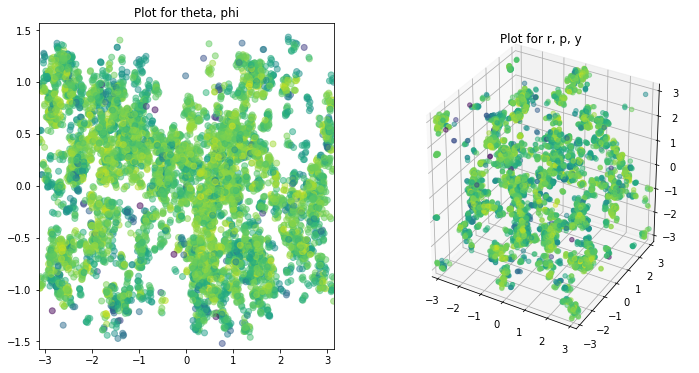

First 200 scores: [66, 98, 80, 89, 93, 70, 92, 85, 51, 84, 95, 85, 94, 75, 89, 84, 72, 63, 83, 91, 78, 82, 62, 64, 94, 85, 73, 91, 74, 83, 73, 73, 87, 83, 55, 68, 77, 79, 79, 71, 88, 84, 97, 82, 92, 84, 99, 81, 84, 81, 70, 86, 73, 68, 76, 98, 70, 85, 70, 96, 86, 90, 74, 91, 96, 97, 91, 80, 81, 89, 76, 93, 97, 60, 87, 78, 87, 74, 78, 94, 90, 93, 66, 92, 89, 85, 79, 87, 88, 79, 62, 94, 91, 94, 78, 88, 50, 84, 88, 65, 85, 55, 82, 98, 91, 93, 84, 83, 82, 97, 76, 86, 63, 80, 90, 69, 79, 89, 95, 74, 84, 100, 68, 86, 100, 80, 86, 72, 80, 33, 90, 62, 65, 93, 94, 92, 69, 73, 91, 76, 89, 93, 88, 85, 86, 82, 88, 73, 97, 83, 86, 89, 87, 53, 85, 94, 87, 92, 83, 83, 84, 89, 81, 82, 88, 94, 90, 50, 77, 79, 87, 95, 90, 74, 86, 86, 80, 98, 82, 78, 93, 87, 98, 95, 71, 91, 96, 88, 94, 97, 64, 74, 66, 72, 61, 83, 86, 92, 92, 91]
Non-match ratio: 0.000000 (0/656249)
Sigma: ['0.013446', '0.013446', '0.013446', '0.013446', '0.013446']
Epsilon: 1.771470
Iteration: 26
Elapsed time: 319.567576s


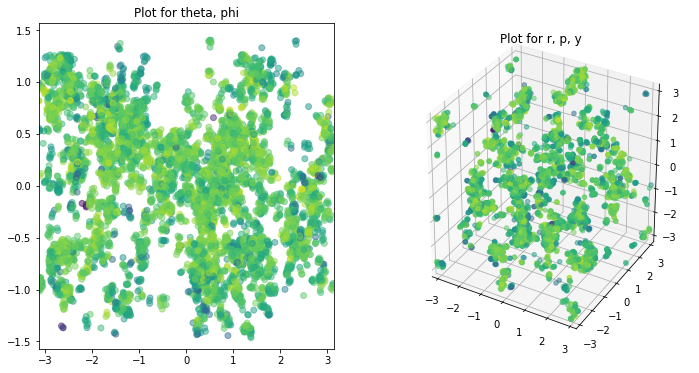

First 200 scores: [91, 96, 89, 64, 82, 88, 87, 79, 71, 94, 93, 83, 69, 85, 87, 79, 99, 83, 82, 78, 94, 93, 58, 92, 99, 41, 91, 88, 90, 85, 93, 77, 91, 84, 88, 87, 95, 78, 98, 82, 93, 89, 93, 77, 77, 78, 81, 84, 68, 81, 92, 93, 78, 88, 90, 98, 96, 81, 94, 79, 78, 93, 90, 54, 92, 101, 91, 77, 91, 82, 91, 94, 98, 90, 53, 89, 73, 84, 79, 64, 86, 86, 82, 80, 72, 88, 97, 83, 77, 88, 78, 88, 93, 84, 89, 81, 78, 96, 65, 99, 90, 80, 99, 62, 89, 88, 81, 90, 73, 75, 78, 84, 72, 93, 90, 85, 94, 62, 83, 57, 52, 79, 79, 85, 86, 99, 96, 73, 73, 93, 85, 85, 92, 80, 57, 59, 84, 74, 88, 96, 71, 83, 72, 86, 70, 86, 87, 58, 78, 83, 79, 92, 92, 76, 86, 80, 86, 79, 93, 80, 72, 83, 93, 68, 74, 89, 89, 107, 84, 81, 55, 91, 87, 86, 78, 82, 92, 73, 77, 65, 76, 74, 74, 75, 84, 90, 87, 85, 94, 80, 85, 88, 79, 67, 85, 84, 84, 92, 86, 89]
Non-match ratio: 0.000000 (0/668098)
Sigma: ['0.013446', '0.013446', '0.013446', '0.013446', '0.013446']
Epsilon: 1.771470
Iteration: 30
Elapsed time: 371.452382s


In [215]:
from helpers import ParticleFilter, generateSamples
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import time

n_corr = 0
start_time = time.time()
# ---------------------------------------------------------
# Adjustable parameters
# ---------------------------------------------------------

iterations = 30
m = 8000

# Set range to be a uniform cube of length 1 around the solution
# ranges = np.array([[*diff_sph-0.5, 1/m], [*diff_sph+0.5, 1/m]]).T  

ranges = np.array([[-pi, pi],
                   [-pi/2, pi/2],
                   [-pi, pi], 
                   [-pi, pi], 
                   [-pi, pi], 
                   [1/m, 1/m]])

e = 3
sigma = np.array([*[0.08]*5]) 

# Multiply sigma by a factor after a number of iterations
sigma_factor   = 0.7
sigma_interval = 5 

# Multiply epsilon by a factor after a number of iterations
e_factor   = 0.9 #0.5
e_interval = 5

# ---------------------------------------------------------

S_new = generateSamples(m, ranges)

for i in range(iterations):
    S_new, score_list, nmc, mc = ParticleFilter(S_new, sigma, pts1, pts2, n_corr, epsilon = e, epipole_t = 0.3, norm_mode = 'softmax')
    
    # Print for every 5 iterations, and for the last iteration
    if i%5 == 0 or i+1 == iterations: 
        fig = plt.figure(figsize = (18,6))

        ax1 = fig.add_subplot(131)
        ax1.scatter(*S_new[:2,:], c= score_list, alpha=0.5)
        ax1.set_xlim(*ranges[0])
        ax1.set_ylim(*ranges[1])
        ax1.set_title("Plot for theta, phi")
        
        ax2 = fig.add_subplot(132, projection='3d')
        ax2.scatter(*S_new[2:5,:], c= score_list, alpha=0.5)
        ax2.set_xlim3d(*ranges[2])
        ax2.set_ylim3d(*ranges[3])
        ax2.set_zlim3d(*ranges[4])
        ax2.set_title("Plot for r, p, y")
        
        if S_new.shape[0] == 8:
            ax3 = fig.add_subplot(133)
            ax3.scatter(*S_new[5:7,:], c= score_list, alpha=0.5)
            ax3.set_xlim(*ranges[5])
            ax3.set_ylim(*ranges[6])
            ax3.set_title("Plot for f1, f2")

        plt.show()

        print("First 200 scores: " + str(score_list[:200])) # print first 200 scores only
        print("Non-match ratio: %f (%d/%d)" % (nmc/mc, nmc, mc))
        print("Sigma: " + str(["{0:f}".format(s) for s in sigma]))
        print("Epsilon: %f" % (e))
        print("Iteration: %d" % (i+1))
        print("Elapsed time: %fs" % (time.time() - start_time))
        
    # Decrease sigma over iterations
    if sigma_factor != 1 and (i+1) % sigma_interval == 0:
        sigma *= sigma_factor
    
    # Decrease epsilon over iterations
    if e_factor != 1 and (i+1) % e_interval == 0:
        e *= e_factor

## Recover solution from Particle Filter

[[ 0.23163882  0.10459808 -1.42715913  1.23076176 -1.84714738]
 [ 0.91774693 -0.01880474  1.98378652  0.02511074 -1.58934295]
 [-1.48673759  0.09296935 -0.02694299 -2.40395841 -0.71634028]
 [-1.65451679 -0.0144734   0.70898063  1.61817969  0.97850037]
 [ 0.91152691 -0.09002701 -0.40441185 -1.34745487  2.07949034]]


C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


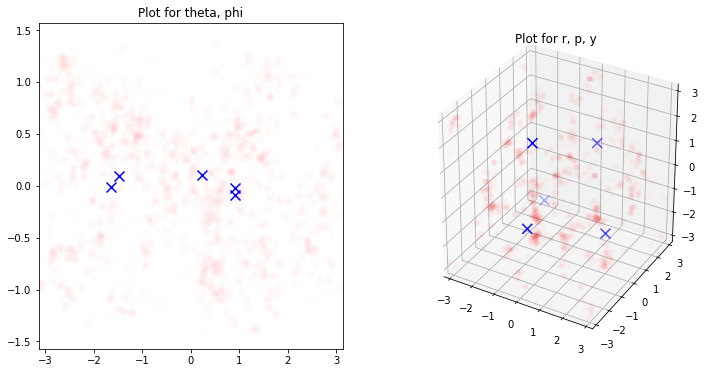

In [222]:
# Retrieve clusters
from sklearn.cluster import KMeans

num_clusters = 5

kmeans_model = KMeans(n_clusters = num_clusters).fit(S_new[:-1, :].T)
results = kmeans_model.cluster_centers_
print(results)

res = results.T

fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax1.scatter(*S_new[:2,:m//4], c='red', alpha=0.01)
ax1.scatter(*res[:2,:], c='blue', marker='x', s=100)
ax1.set_xlim(*ranges[0])
ax1.set_ylim(*ranges[1])
ax1.set_title("Plot for theta, phi")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(*S_new[2:,:m//4], c='red', alpha=0.01)
ax2.scatter(*res[2:,:], zdir='z', c='blue', marker='x', s=100)
ax2.set_xlim3d(*ranges[2])
ax2.set_ylim3d(*ranges[3])
ax2.set_zlim3d(*ranges[4])
ax2.set_title("Plot for r, p, y")
plt.show()

In [223]:
# Construct E from solution t and r, check that (pts1)' E (pts2) = 0

from helpers import rpy2R, xyz2T, sphericalToCartesian

pts1_uvf = np.concatenate((pts1, np.ones((pts1.shape[0], 1))), axis = 1)
pts2_uvf = np.concatenate((pts2, np.ones((pts2.shape[0], 1))), axis = 1)

E_results = []
E_products = []

for res_idx in range(results.shape[0]):
    t  = sphericalToCartesian(1, *results[res_idx, :2])
    r  = results[res_idx, 2:]
    
    T = xyz2T(t[0], t[1], t[2])
    R = rpy2R(r[0], r[1], r[2])
    E = np.dot(T,R)
    E_results.append(E)
    E_products.append(pts1_uvf @ E @ pts2_uvf.T)

In [224]:
E_results

[array([[-0.24550164, -0.94637283, -0.1837961 ],
        [-0.1366061 ,  0.22530189, -0.96436679],
        [ 0.02837702,  0.09126788,  0.04202184]]),
 array([[ 2.05140682e-03,  4.24148514e-01,  9.05518245e-01],
        [ 1.88652744e-02, -9.05405864e-01,  4.23864701e-01],
        [ 3.05235267e-04, -8.67729186e-03,  1.66789694e-02]]),
 array([[-0.04051265,  0.79536714, -0.60472232],
        [ 0.74556614,  0.4236445 ,  0.50606204],
        [ 0.06958689,  0.03313402,  0.0517516 ]]),
 array([[-0.37539323, -0.49550631,  0.78329557],
        [ 0.42469914,  0.65912138,  0.62046889],
        [-0.00567137, -0.00890722, -0.00989756]]),
 array([[-0.12879562, -0.57031346, -0.80939574],
        [-0.49403412, -0.66686221,  0.5533307 ],
        [-0.04237292, -0.0791184 , -0.00527293]])]

Comparing all n' x n matches


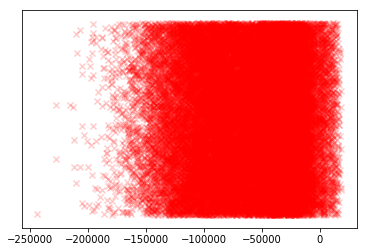

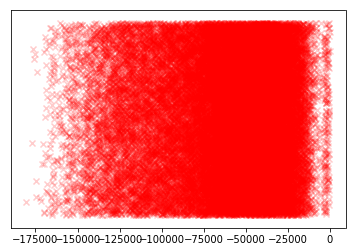

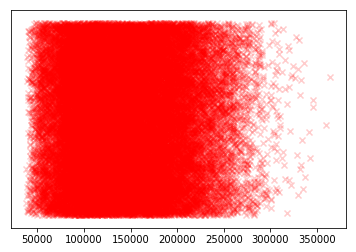

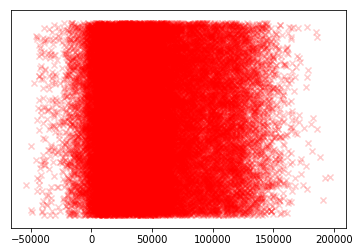

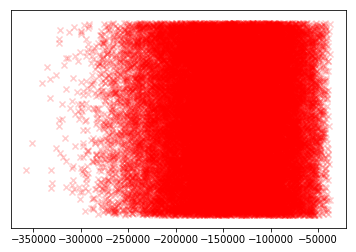

In [225]:
print("Comparing all n' x n matches")
for sol in E_products:
    vals = sol.flatten()
    plt.scatter(vals, np.random.rand(vals.shape[0]), marker='x', color='r', alpha = 0.2)
    plt.yticks([])
    plt.show()

## Plot epipolar lines with E

In [59]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c,ch = img1.shape
    
    img1 = img1.copy()
    img2 = img2.copy()
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        y0,x0 = map(int, [0, -r[2]/r[1] ])
        y1,x1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple([pt1[1],pt1[0]]),4,color,-1)
        img2 = cv2.circle(img2,tuple([pt2[1],pt2[0]]),4,color,-1)
    return img1,img2

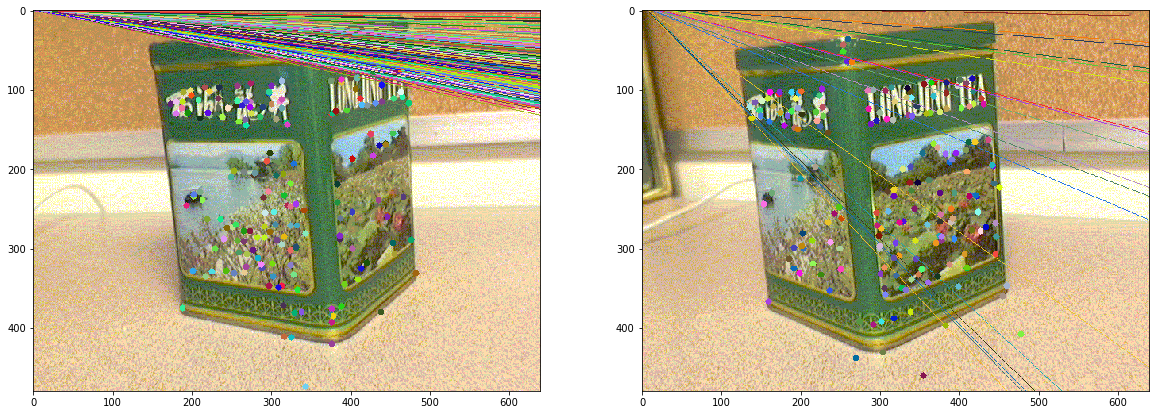

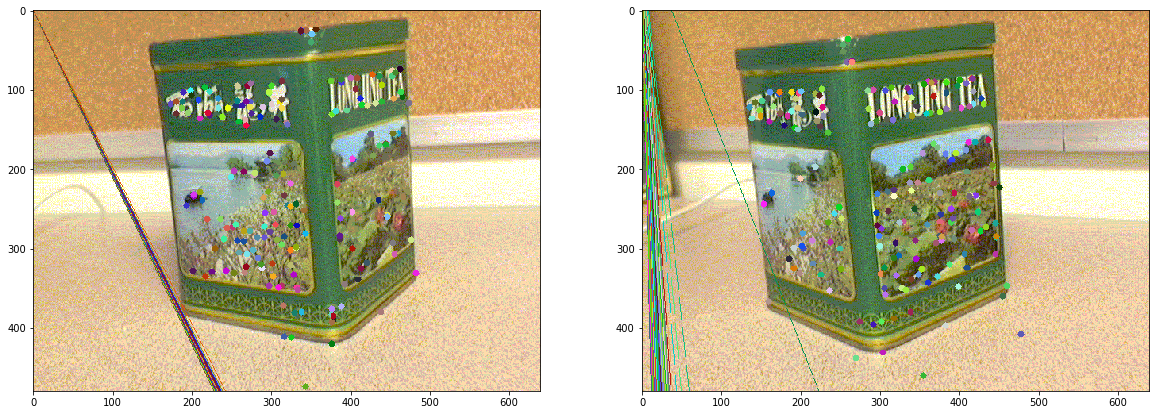

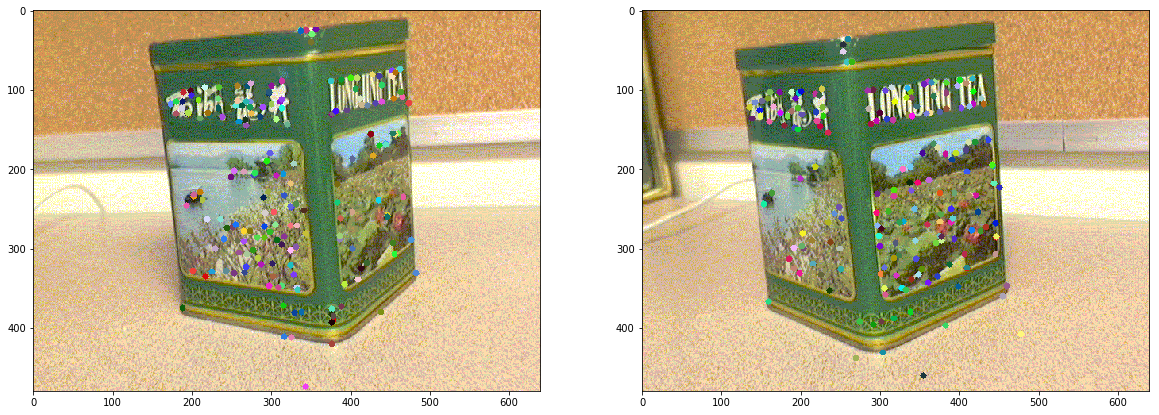

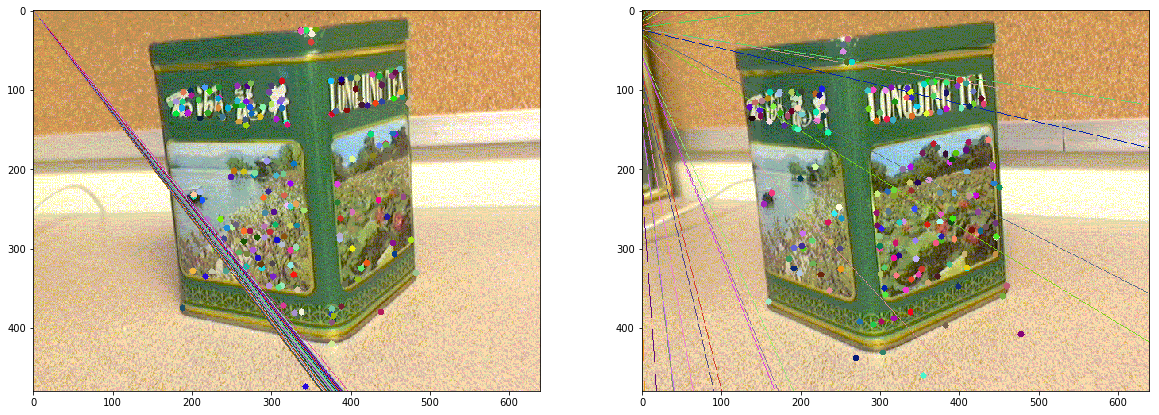

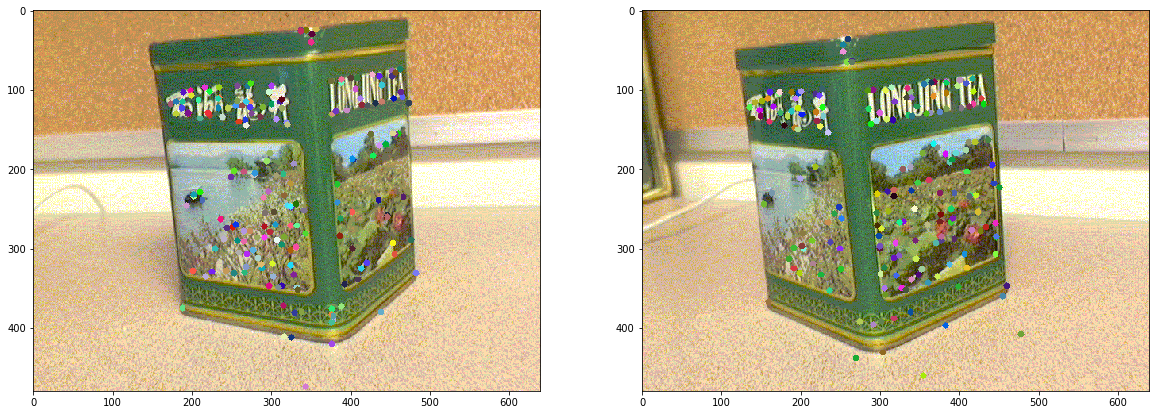

In [227]:
for E in E_results:
    # Find epilines corresponding to points (whichImage contains the points, the other image contains lines)

    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 1, E)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,pts1.astype(int),pts2.astype(int))

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image

    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 2, E)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,pts2.astype(int),pts1.astype(int))

    plt.figure(2, figsize=(20,10))
    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img3)
    plt.show()

In [40]:
del img3, img4, img5, img6

## 4. Run Particle Filter with resampling mode - ComputeF


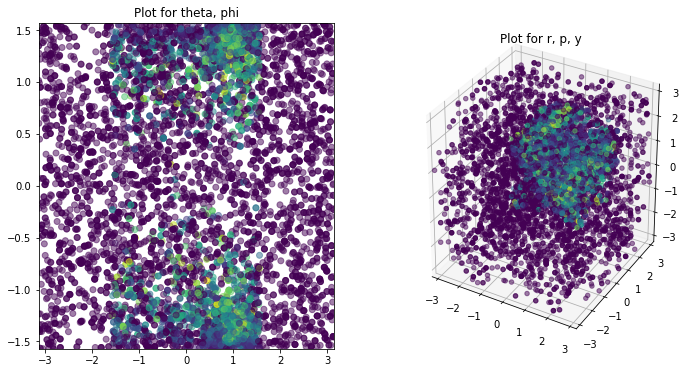

First 200 scores: [12, 0, 0, 0, 0, 41, 80, 71, 0, 19, 35, 0, 0, 0, 0, 65, 0, 45, 0, 0, 0, 49, 31, 38, 37, 0, 0, 0, 0, 0, 0, 0, 62, 35, 37, 14, 0, 0, 0, 12, 62, 0, 67, 89, 68, 102, 0, 8, 37, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 90, 0, 85, 0, 0, 0, 40, 61, 16, 42, 22, 0, 14, 0, 70, 9, 0, 9, 30, 77, 31, 15, 0, 0, 0, 0, 26, 39, 0, 0, 73, 35, 21, 114, 0, 0, 0, 0, 0, 46, 72, 0, 0, 0, 0, 55, 0, 46, 0, 0, 0, 0, 0, 10, 67, 14, 0, 0, 0, 38, 0, 0, 0, 0, 0, 50, 0, 0, 40, 21, 60, 29, 25, 0, 55, 45, 30, 108, 77, 0, 0, 0, 0, 0, 0, 0, 0, 81, 0, 93, 0, 65, 0, 0, 57, 0, 0, 15, 0, 36, 0, 0, 0, 0, 67, 0, 105, 33, 80, 82, 0, 0, 0, 0, 0, 0, 13, 36, 0, 105, 0, 0, 30, 8, 0, 96, 38, 0, 0, 0, 0, 0, 0, 92, 15, 16, 62, 23, 0, 82, 0]
Non-match ratio: 0.000000 (0/171506)
Sigma: ['0.080000', '0.080000', '0.080000', '0.080000', '0.080000']
Epsilon: 5.000000
Iteration: 1
Elapsed time: 22.718788s


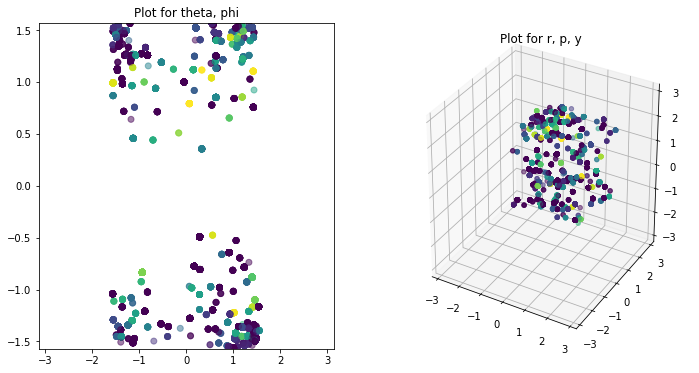

First 200 scores: [77, 9, 31, 49, 9, 25, 9, 92, 0, 23, 0, 0, 9, 9, 0, 9, 46, 0, 0, 43, 57, 0, 24, 0, 0, 0, 12, 43, 94, 0, 77, 0, 0, 0, 91, 59, 0, 41, 0, 17, 77, 31, 0, 0, 0, 0, 34, 74, 24, 0, 20, 0, 41, 12, 0, 0, 0, 25, 0, 0, 0, 12, 91, 57, 0, 0, 0, 0, 9, 61, 0, 90, 0, 48, 19, 0, 60, 0, 0, 71, 0, 0, 0, 54, 17, 0, 25, 0, 0, 22, 53, 0, 19, 46, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 57, 95, 43, 28, 0, 43, 61, 57, 57, 0, 22, 61, 0, 77, 94, 0, 0, 61, 0, 63, 0, 0, 17, 9, 51, 0, 42, 12, 0, 43, 0, 0, 43, 0, 48, 0, 38, 14, 55, 43, 57, 0, 77, 38, 51, 28, 0, 31, 43, 0, 57, 0, 0, 12, 0, 17, 57, 12, 57, 12, 24, 57, 0, 0, 0, 23, 51, 14, 58, 0, 0, 61, 9, 61, 61, 52, 0, 0, 0, 0, 0, 52, 14, 40, 43, 0, 75, 0, 0, 34, 25, 0]
Non-match ratio: 0.000000 (0/182453)
Sigma: ['0.056000', '0.056000', '0.056000', '0.056000', '0.056000']
Epsilon: 4.500000
Iteration: 6
Elapsed time: 152.695331s


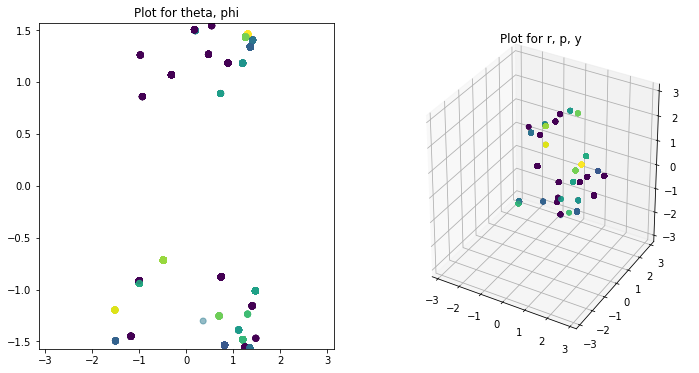

First 200 scores: [0, 0, 61, 65, 0, 61, 44, 0, 61, 65, 61, 61, 61, 61, 0, 61, 61, 0, 65, 61, 0, 61, 61, 44, 51, 0, 61, 61, 51, 0, 0, 65, 61, 44, 61, 0, 61, 61, 61, 0, 0, 40, 0, 61, 24, 61, 61, 61, 51, 61, 40, 61, 61, 73, 0, 61, 61, 61, 51, 0, 61, 61, 61, 0, 61, 24, 61, 65, 21, 30, 0, 61, 61, 61, 61, 0, 42, 0, 65, 47, 65, 0, 61, 0, 0, 61, 60, 0, 65, 61, 0, 40, 61, 61, 77, 61, 65, 30, 21, 24, 21, 0, 61, 61, 0, 65, 65, 61, 61, 65, 0, 61, 44, 61, 42, 24, 61, 29, 0, 61, 61, 61, 61, 61, 61, 0, 61, 61, 61, 61, 0, 61, 65, 61, 0, 0, 61, 44, 73, 61, 0, 61, 65, 61, 61, 65, 24, 61, 0, 61, 61, 0, 65, 0, 61, 0, 61, 65, 61, 47, 65, 51, 61, 0, 51, 0, 61, 0, 61, 21, 61, 44, 65, 0, 35, 61, 24, 61, 44, 21, 65, 61, 73, 61, 0, 21, 0, 61, 0, 61, 61, 61, 0, 61, 21, 61, 65, 61, 0, 61]
Non-match ratio: 0.000000 (0/311103)
Sigma: ['0.056000', '0.056000', '0.056000', '0.056000', '0.056000']
Epsilon: 4.500000
Iteration: 10
Elapsed time: 244.175541s


In [153]:
from helpers import ParticleFilter, generateSamples
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import time

n_corr = 0
start_time = time.time()
# ---------------------------------------------------------
# Adjustable parameters
# ---------------------------------------------------------

iterations = 10
m = 8000

# Set range to be a uniform cube of length 1 around the solution
# ranges = np.array([[*diff_sph-0.5, 1/m], [*diff_sph+0.5, 1/m]]).T  

ranges = np.array([[-pi, pi],
                   [-pi/2, pi/2],
                   [-pi, pi], 
                   [-pi, pi], 
                   [-pi, pi], 
                   [1/m, 1/m]])

e = 5
sigma = np.array([*[0.08]*5]) 

# Multiply sigma by a factor after a number of iterations
sigma_factor   = 0.7
sigma_interval = 5 

# Multiply epsilon by a factor after a number of iterations
e_factor   = 0.9 #0.5
e_interval = 5

# ---------------------------------------------------------

S_new = generateSamples(m, ranges)

for i in range(iterations):
    S_new, score_list, nmc, mc = ParticleFilter(S_new, sigma, pts1, pts2, n_corr, epsilon = e, epipole_t = 0.3, 
                                                norm_mode = 'softmax', resampling = "ComputeF")
    
    # Print for every 5 iterations, and for the last iteration
    if i%5 == 0 or i+1 == iterations: 
        fig = plt.figure(figsize = (18,6))

        ax1 = fig.add_subplot(131)
        ax1.scatter(*S_new[:2,:], c= score_list, alpha=0.5)
        ax1.set_xlim(*ranges[0])
        ax1.set_ylim(*ranges[1])
        ax1.set_title("Plot for theta, phi")
        
        ax2 = fig.add_subplot(132, projection='3d')
        ax2.scatter(*S_new[2:5,:], c= score_list, alpha=0.5)
        ax2.set_xlim3d(*ranges[2])
        ax2.set_ylim3d(*ranges[3])
        ax2.set_zlim3d(*ranges[4])
        ax2.set_title("Plot for r, p, y")
        
        if S_new.shape[0] == 8:
            ax3 = fig.add_subplot(133)
            ax3.scatter(*S_new[5:7,:], c= score_list, alpha=0.5)
            ax3.set_xlim(*ranges[5])
            ax3.set_ylim(*ranges[6])
            ax3.set_title("Plot for f1, f2")

        plt.show()

        print("First 200 scores: " + str(score_list[:200])) # print first 200 scores only
        print("Non-match ratio: %f (%d/%d)" % (nmc/mc, nmc, mc))
        print("Sigma: " + str(["{0:f}".format(s) for s in sigma]))
        print("Epsilon: %f" % (e))
        print("Iteration: %d" % (i+1))
        print("Elapsed time: %fs" % (time.time() - start_time))
        
    # Decrease sigma over iterations
    if sigma_factor != 1 and (i+1) % sigma_interval == 0:
        sigma *= sigma_factor
    
    # Decrease epsilon over iterations
    if e_factor != 1 and (i+1) % e_interval == 0:
        e *= e_factor

## Recover solution from Particle Filter

(5, 4000)
[[ 1.26506883  1.43331913 -0.20256996  2.87679205 -1.02646065]
 [-0.51836717 -0.73087693 -0.67287841  1.23427781  1.45374976]]


C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


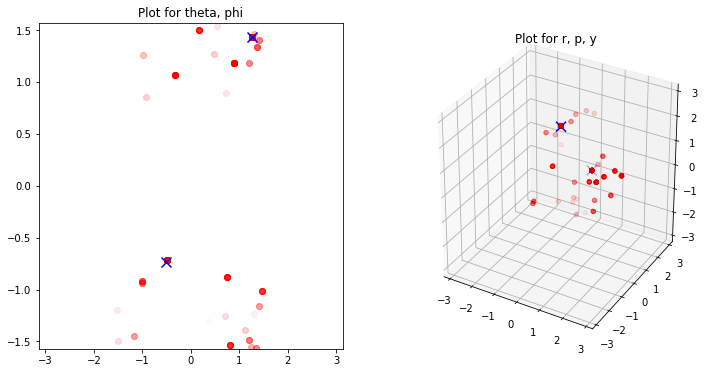

In [205]:
# Retrieve highest-scoring points
from sklearn.cluster import KMeans

n_results = 4000
results = S_new[:,S_new[-1,:].argsort()][:-1, -n_results:].T
res = results.T
print(res.shape)

# Retrieve clusters
from sklearn.cluster import KMeans

num_clusters = 2

kmeans_model = KMeans(n_clusters = num_clusters, max_iter=1000).fit(results)
results = kmeans_model.cluster_centers_
res = results.T
print(results)

fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax1.scatter(*S_new[:2,:m//4], c='red', alpha=0.02)
ax1.scatter(*res[:2,:], c='blue', marker='x', s=100)
ax1.set_xlim(*ranges[0])
ax1.set_ylim(*ranges[1])
ax1.set_title("Plot for theta, phi")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(*S_new[2:,:m//4], c='red', alpha=0.02)
ax2.scatter(*res[2:,:], zdir='z', c='blue', marker='x', s=100)
ax2.set_xlim3d(*ranges[2])
ax2.set_ylim3d(*ranges[3])
ax2.set_zlim3d(*ranges[4])
ax2.set_title("Plot for r, p, y")
plt.show()

In [206]:
# Construct E from solution t and r, check that (pts1)' E (pts2) = 0

from helpers import rpy2R, xyz2T, sphericalToCartesian

pts1_uvf = np.concatenate((pts1, np.ones((pts1.shape[0], 1))), axis = 1)
pts2_uvf = np.concatenate((pts2, np.ones((pts2.shape[0], 1))), axis = 1)

E_results2 = []
E_products2 = []
for res_idx in range(results.shape[0]):
    t  = sphericalToCartesian(1, *results[res_idx, :2])
    r  = results[res_idx, 2:]
    
    T = xyz2T(t[0], t[1], t[2])
    R = rpy2R(r[0], r[1], r[2])
    E = np.dot(T,R)
    E_results2.append(E)
    E_products2.append(pts1_uvf @ E @ pts2_uvf.T)

Comparing all n' x n matches


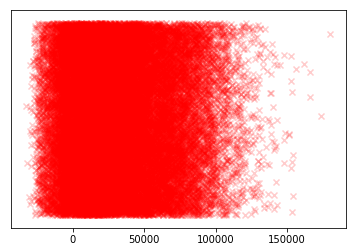

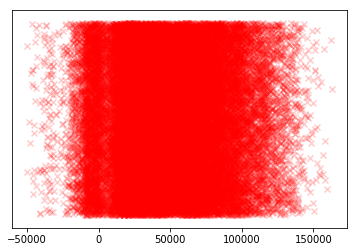

In [207]:
print("Comparing all n' x n matches")
for sol in E_products2:
    vals = sol.flatten()
    plt.scatter(vals, np.random.rand(vals.shape[0]), marker='x', color='r', alpha = 0.2)
    plt.yticks([])
    plt.show()

## Plot epipolar lines with E

In [208]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c,ch = img1.shape
    
    img1 = img1.copy()
    img2 = img2.copy()
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        y0,x0 = map(int, [0, -r[2]/r[1] ])
        y1,x1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple([pt1[1],pt1[0]]),4,color,-1)
        img2 = cv2.circle(img2,tuple([pt2[1],pt2[0]]),4,color,-1)
    return img1,img2

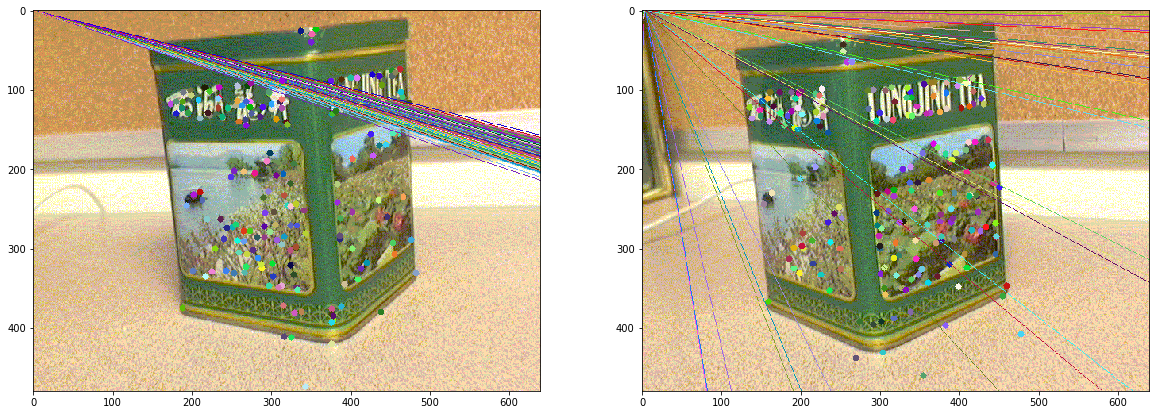

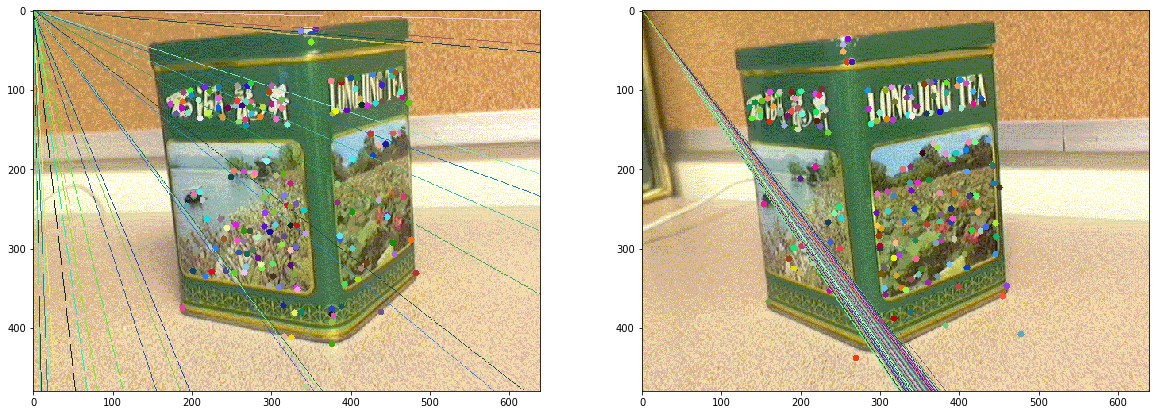

In [209]:
for E in E_results2:
    # Find epilines corresponding to points (whichImage contains the points, the other image contains lines)

    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 1, E)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,pts1.astype(int),pts2.astype(int))

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image

    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 2, E)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,pts2.astype(int),pts1.astype(int))

    plt.figure(2, figsize=(20,10))
    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img3)
    plt.show()

## Estimate ground truth for comparison


In [49]:
# Hand-pick correspondences for ground truth
c1 = np.array([[375., 188.],
               [118., 173.],
               [330., 482.],
               [188., 402.],
               [246., 193.],
               [144., 320.],
               [131., 376.],
               [30. , 351.],
               [109., 465.]
              ])

c2 = np.array([[367., 159.],
               [122., 135.],
               [347., 459.],
               [200., 328.],
               [244., 153.],
               [154., 234.],
               [143., 288.],
               [43. , 253.],
               [118., 430.]
              ])

F, inliers = cv2.findEssentialMat(c2,c1)
print("Inliers:" + str(sum(inliers)[0]) + '/' + str(inliers.shape[0]))
print("F shape: " + str(F.shape))

Inliers:8/9
F shape: (3, 3)


In [60]:
lines1 = cv2.computeCorrespondEpilines(c2.reshape(-1,1,2), 1, F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,c1.astype(int),c2.astype(int))

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image

lines2 = cv2.computeCorrespondEpilines(c1.reshape(-1,1,2), 2, F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,c2.astype(int),c1.astype(int))


Estimated ground truth from hand-picked coordinates


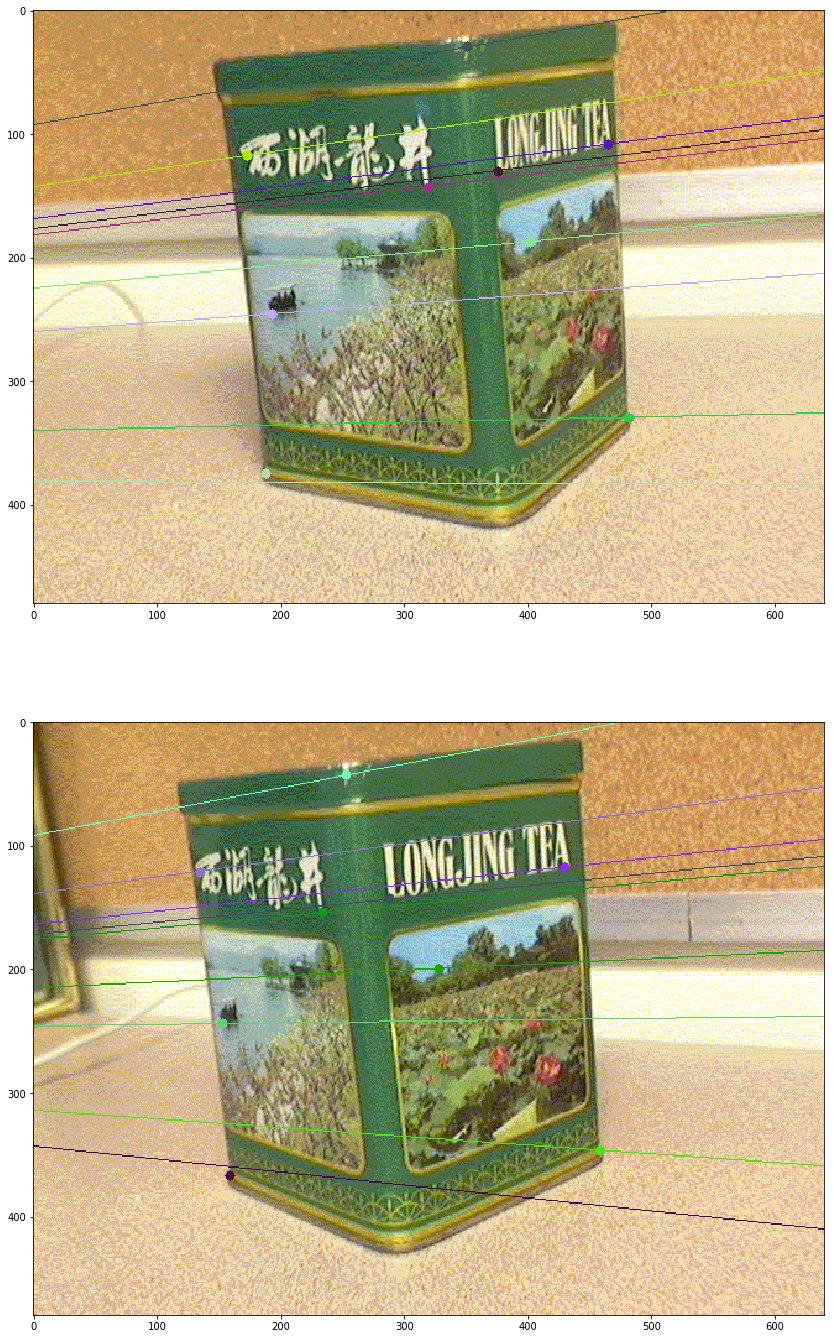

In [63]:
print("Estimated ground truth from hand-picked coordinates")
plt.figure(2, figsize=(16,24))
plt.subplot(211),plt.imshow(img5)
plt.subplot(212),plt.imshow(img3)
plt.show()